In [1]:
print(1111)

1111


In [2]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange


In [3]:

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [4]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # TESTED
    # Only works for the last dimension (dim=-1)
    dim = -1
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, dim)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.0

    return cumprod

def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

def get_ray_bundle(
    height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor
):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
        torch.arange(
            width, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ).to(tform_cam2world),
        torch.arange(
            height, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ),
    )
    directions = torch.stack(
        [
            (ii - width * 0.5) / focal_length,
            -(jj - height * 0.5) / focal_length,
            -torch.ones_like(ii),
        ],
        dim=-1,
    )
    ray_directions = torch.sum(
        directions[..., None, :] * tform_cam2world[:3, :3], dim=-1
    )
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
        tensor (torch.Tensor): Input tensor to be positionally encoded.
        encoding_size (optional, int): Number of encoding functions used to compute
            a positional encoding (default: 6).
        include_input (optional, bool): Whether or not to include the input in the
            positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

In [5]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True,
) -> (torch.Tensor, torch.Tensor):
    r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
    variables indicate the bounds within which 3D points are to be sampled.

    Args:
        ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
          coordinate that is of interest/relevance).
        far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
          coordinate that is of interest/relevance).
        num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
          randomly, whilst trying to ensure "some form of" uniform spacing among them.
        randomize (optional, bool): Whether or not to randomize the sampling of query points.
          By default, this is set to `True`. If disabled (by setting to `False`), we sample
          uniformly spaced points along each ray in the "bundle".

    Returns:
        query_points (torch.Tensor): Query points along each ray
          (shape: :math:`(width, height, num_samples, 3)`).
        depth_values (torch.Tensor): Sampled depth values along each ray
          (shape: :math:`(num_samples)`).
    """
    # TESTED
    # shape: (num_samples)
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize is True:
        # ray_origins: (width, height, 3)
        # noise_shape = (width, height, num_samples)
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        # depth_values: (num_samples)
        depth_values = (
            depth_values
            + torch.rand(noise_shape).to(ray_origins)
            * (far_thresh - near_thresh)
            / num_samples
        )
    # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
    # query_points:  (width, height, num_samples, 3)
    query_points = (
        ray_origins[..., None, :]
        + ray_directions[..., None, :] * depth_values[..., :, None]
    )
    # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
    return query_points, depth_values




In [6]:
def render_volume_density(
    radiance_field: torch.Tensor, ray_origins: torch.Tensor, depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

    Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
    """
    # TESTED
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat(
        (
            depth_values[..., 1:] - depth_values[..., :-1],
            one_e_10.expand(depth_values[..., :1].shape),
        ),
        dim=-1,
    )
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map



In [7]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(
    height,
    width,
    focal_length,
    tform_cam2world,
    near_thresh,
    far_thresh,
    depth_samples_per_ray,
    encoding_function,
    get_minibatches_function,
    chunksize,
    model,
    encoding_function_args,
):

    # Get the "bundle" of rays through all image pixels.
    ray_origins, ray_directions = get_ray_bundle(
        height, width, focal_length, tform_cam2world
    )

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    # Encode the query points (default: positional encoding).
    encoded_points = encoding_function(flattened_query_points, encoding_function_args)

    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches_function(encoded_points, chunksize=chunksize)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # "Unflatten" to obtain the radiance field.
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_predicted, _, _ = render_volume_density(
        radiance_field, ray_origins, depth_values
    )

    return rgb_predicted

In [8]:
class VeryTinyNerfModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """

    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [9]:
# def main():

# Determine device to run on (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Log directory
logdir = os.path.join("./", "cache", "log")
os.makedirs(logdir, exist_ok=True)

"""
Load input images and poses
"""

data = np.load("cache/tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.0
far_thresh = 6.0

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 10
# Specify encoding function.
encode = positional_encoding
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory (when using 8
# samples per ray).
chunksize = 4096

# Optimizer parameters
lr = 5e-3
num_iters = 5000

# Misc parameters
display_every = 100  # Number of iters after which stats are

weightpath = 'weight_smallnerf.tensor'


cuda


In [10]:
print('All camera data shape: ',tform_cam2world.shape)
print('Camera data sample:\n',tform_cam2world[0])
print('We need ',3*4, ' outputs from camera network in order to make valid matrix.')

print('Shape of input image is: ',images[0].shape)
print('So we use convolutions.')
print('-'*12)



All camera data shape:  torch.Size([106, 4, 4])
Camera data sample:
 tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
        [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
        [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
We need  12  outputs from camera network in order to make valid matrix.
Shape of input image is:  torch.Size([100, 100, 3])
So we use convolutions.
------------


In [11]:
# class CameraNet(torch.nn.Module):
#     def __init__(self, emb_dim=32):
#         super().__init__()

#         # kernel_sizes = [1,21,13,9,7,5,3,3]
#         kernel_sizes = [3,3,3]
#         convolutions = []
#         for i in range(len(kernel_sizes)):
#             if i == 0:
#                 cnn = torch.nn.Conv2d(3, emb_dim, kernel_sizes[i])
#             else:
#                 cnn = torch.nn.Conv2d(emb_dim, emb_dim, kernel_sizes[i])
#             convolutions += [cnn]
#         self.convs = torch.nn.ModuleList(convolutions)        
#         self.activation = torch.nn.SiLU()

#         self.output_map = torch.nn.Linear(94*94*emb_dim, 12)
#         self.out_activation = torch.nn.Tanh()

#     def forward(self, x):
#         for cnn_layer in self.convs:
#             x = cnn_layer(x)
#             x = self.activation(x)
        
#         x = x.flatten()
#         x = self.output_map(x)
#         x = self.out_activation(x)
#         return x

# class CameraNet(torch.nn.Module):
#     def __init__(self, emb_dim=32):
#         super().__init__()

#         # kernel_sizes = [1,21,13,9,7,5,3,3]
#         self.convs = []
#         kernel_sizes = [3,3,3]
#         for i in range(3):
#             convolutions = []
#             for i in range(len(kernel_sizes)):
#                 if i == 0:
#                     cnn = torch.nn.Conv2d(3, emb_dim, kernel_sizes[i])
#                 else:
#                     cnn = torch.nn.Conv2d(emb_dim, emb_dim, kernel_sizes[i])
#                 convolutions += [cnn]
#             self.convs += [torch.nn.ModuleList(convolutions)]        
#         self.convs = torch.nn.ModuleList(self.convs)
#         self.activation = torch.nn.SiLU()

#         self.output_map = torch.nn.Linear(94*94*emb_dim*3, 12)
#         # self.output_map = torch.nn.Linear(46*46*emb_dim*3, 12)
#         self.out_activation = torch.nn.Tanh()

    # def forward(self, x):
    #     outs = []
    #     for cnns in self.convs:
    #         h = x
    #         for cnn_layer in cnns:
    #             h = cnn_layer(h)
    #             h = self.activation(h)
    #         outs += [h]
    #     x = torch.cat(outs)
    #     x = x.flatten()
    #     x = self.output_map(x)
    #     x = self.out_activation(x)
    #     return x

class CameraNet(torch.nn.Module):
    def __init__(self, emb_dim=32):
        super().__init__()

        
        kernel_sizes = [3,3,3]
        convolutions = []
        linears = []
        for i in range(len(kernel_sizes)):
            if i == 0:
                cnn = torch.nn.Conv2d(3, emb_dim, kernel_sizes[i])
            else:
                cnn = torch.nn.Conv2d(emb_dim, emb_dim, kernel_sizes[i])
            convolutions += [cnn]
            if i < len(kernel_sizes)-1:
                linears += [torch.nn.Conv2d(emb_dim, emb_dim, kernel_sizes[i])]
        self.convs0 = torch.nn.ModuleList(convolutions)     
        self.lins0 = torch.nn.ModuleList(linears)        

        self.map = torch.nn.Linear(94*94*emb_dim, 12)
        # self.output_map = torch.nn.Linear(94*94*emb_dim, 12)

        self.out_activation = torch.nn.Tanh()
        self.activation = torch.nn.SiLU()


    def forward(self, x):
        prev_h = None
        for i in range(len(self.convs0)):
            
            cnn_layer = self.convs0[i]
            x = cnn_layer(x)
            x = self.activation(x)
            if i < len(self.convs0)-1:
                h = self.lins0[i](x)
            if i > 0:
                x = x + prev_h
            prev_h = h
            # print(x.shape, ' | ', h.shape)
        x = x.flatten()
        x = self.map(x)
        x = self.out_activation(x)
        return x

test_image = images[0].permute(2,0,1).float().cpu()

camnet = CameraNet(128)
out = camnet(test_image)
print('Network output: ',out.shape, out.flatten().shape)
# out = out.reshape(3,4)
# cam_param = torch.zeros((4,4))#, requires_grad=True)
# cam_param[:3] = out
# cam_param[3,3] = 1
# cam_param

Network output:  torch.Size([12]) torch.Size([12])


In [12]:
camnet = CameraNet(128).to(device)
cam_opt = torch.optim.Adam(camnet.parameters(), lr=5e-5)

def get_parameters(image):
    out = camnet(image.permute(2,0,1))
    # print('Network output: ',out.shape, out.flatten().shape)
    out = out.reshape(3,4).to(device)
    cam_param = torch.zeros((4,4)).to(device)#, requires_grad=True)
    cam_param[:3] = out
    cam_param[3,3] = 1
    return cam_param

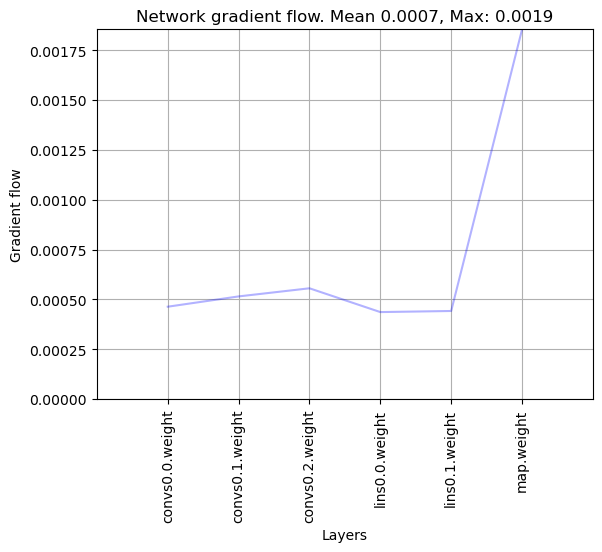

In [13]:

cam_opt.zero_grad()

out = get_parameters(images[0].to(device))
target = tform_cam2world[0].to(device)

loss = torch.nn.functional.mse_loss(out, target)
loss.backward()

# plot_grad
net = camnet
def plot_grad_flow(net):
    avg_grads = []
    layers_names = []
    for name, param in net.named_parameters():
        if param.requires_grad and 'bias' not in name:
            layers_names += [name]
            avg_grads += [param.grad.abs().mean().detach().cpu()]


    plt.plot(avg_grads, alpha=0.3, color='b')
    # plt.hlines(0,-1,len(avg_grads)+1, linewidth=1, color='k')
    plt.xticks(range(0,len(layers_names)), layers_names, rotation='vertical')
    plt.xlim(-1, len(avg_grads))
    plt.ylim(0, max(avg_grads))

    # plt.yscale('log')
    plt.xlabel('Layers')
    plt.ylabel('Gradient flow')
    plt.title('Network gradient flow. Mean {:.4f}, Max: {:.4f}'.format(np.mean(avg_grads), np.max(avg_grads)))
    plt.grid(True)
    plt.show()

plot_grad_flow(net)

## Train

In [14]:
'''
/home/ivan/miniconda3/envs/humannerf/bin/tensorboard --logdir=runs
'''

'\n/home/ivan/miniconda3/envs/humannerf/bin/tensorboard --logdir=runs\n'

In [122]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [123]:
import io
from PIL import Image

def grad_flow_tb(net, writer, iter, net_name=''):
    avg_grads = []
    layers_names = []
    for name, param in net.named_parameters():
        if param.requires_grad and 'bias' not in name:
            layers_names += [name.split('.')[0]]
            avg_grads += [param.grad.abs().mean().detach().cpu()]

    plt.figure()
    plt.plot(avg_grads, alpha=0.3, color='b')
    # plt.hlines(0,-1,len(avg_grads)+1, linewidth=1, color='k')
    plt.xticks(range(0,len(layers_names)), layers_names, rotation=45)
    plt.xlim(-1, len(avg_grads))
    plt.ylim(0, max(avg_grads))

    # plt.yscale('log')
    plt.xlabel('Layers')
    plt.ylabel('Gradient flow')
    plt.title('Network gradient flow. \nMean {:}, \nMax: {:}'.format(np.mean(avg_grads), np.max(avg_grads)))
    plt.grid(True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    image_graph = Image.open(buf).convert('RGB')
    writer.add_image(f'Image/{net_name}_gradflow', np.array(image_graph), iter, dataformats='HWC')
  
    # plt.show()

# np.array(image_graph).shape
# writer.add_image('Image/camnet_gradflow', np.array(image_graph), 1, dataformats='HWC')
# plt.figure()
# plt.imshow(image_graph)


In [124]:
# i = 0

In [125]:
import matplotlib
matplotlib.use('agg')

"""
Model
"""
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in trange(num_iters):

    # Randomly pick an image as the target.
    target_img_idx = np.random.randint(images.shape[0])
    target_img = images[target_img_idx].to(device)
    # target_tform_cam2world = tform_cam2world[target_img_idx].to(device)
    REAL_target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

    # NEW CAM
    target_tform_cam2world = get_parameters(target_img)

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    rgb_predicted = run_one_iter_of_tinynerf(
        height,
        width,
        focal_length,
        target_tform_cam2world,
        near_thresh,
        far_thresh,
        depth_samples_per_ray,
        encode,
        get_minibatches,
        chunksize,
        model,
        num_encoding_functions,
    )

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()

    # DEBUG grad flow plot
    if i % display_every == 0 or i == num_iters - 1:
        grad_flow_tb(camnet, writer, i, 'camnet')
        grad_flow_tb(model, writer, i, 'nerf')

    optimizer.step()
    cam_opt.step()


    optimizer.zero_grad()
    cam_opt.zero_grad()

    # Display images/plots/stats
    if i % display_every == 0 or i == num_iters - 1:
        # Render the held-out view
        rgb_predicted = run_one_iter_of_tinynerf(
            height,
            width,
            focal_length,
            testpose,
            near_thresh,
            far_thresh,
            depth_samples_per_ray,
            encode,
            get_minibatches,
            chunksize,
            model,
            num_encoding_functions,
        )
        # Compute loss for cameras
        with torch.no_grad():
            cam_loss = torch.nn.functional.mse_loss(
                REAL_target_tform_cam2world, target_tform_cam2world)
            # print('CAMERA LOSS: {:.6f}'.format(cam_loss))

        # Original loss
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        writer.add_scalar('Loss/eval_image', loss.item(), i)
        writer.add_scalar('Loss/eval_camera', cam_loss.item(), i)
        # tqdm.write('Loss: {:.4f} | CAMERA LOSS: {:.6f}'.format(loss.item(), cam_loss))
        # tqdm.write("Loss: " + str(loss.item()))

        # DEBUG grad flow plot
        # grad_flow_tb(camnet, writer, i, 'camnet')
        # grad_flow_tb(model, writer, i, 'nerf')

        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        p_image = rgb_predicted.detach().cpu().numpy()
        p_image = (p_image*255).astype(np.uint8)
        writer.add_image('Pred/image',p_image, i, dataformats='HWC')
        # plt.imshow(p_image)
        # plt.savefig(os.path.join(logdir, str(i).zfill(6) + ".png"))
        # plt.close("all")

        if i == num_iters - 1:
            plt.plot(iternums, psnrs)
            plt.savefig(os.path.join(logdir, "psnr.png"))
            plt.close("all")
        # plt.figure(figsize=(10, 4))
        # plt.subplot(121)
        # plt.imshow(rgb_predicted.detach().cpu().numpy())
        # plt.title(f"Iteration {i}")
        # plt.subplot(122)
        # plt.plot(iternums, psnrs)
        # plt.title("PSNR")
        # plt.show()

# save model
torch.save(model.state_dict(), weightpath)
print('Model saved: ', weightpath)

print("Done!")

# i += 1
# print(i)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/ivan/miniconda3/envs/humannerf/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  app.launch_new_instance()
 12%|█▏        | 596/5000 [00:56<06:57, 10.54it/s]


KeyboardInterrupt: 

In [121]:
writer.close()

In [69]:
# print(loss.grad)
# for i in range(len(camnet.convs)):
#     print(camnet.convs[i].weight.grad.sum())

# plot_grad_flow(camnet)